# Preparing enviroment

In [ ]:
!pip install -q torch transformers accelerate bitsandbytes transformers sentence-transformers faiss-gpu tiktoken chromadb langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
import math
import random
import time
import pandas as pd
from torch import bfloat16
import transformers
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
from transformers import pipeline
import langchain
from langchain.llms import HuggingFacePipeline
from langchain.document_loaders import DataFrameLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter, TokenTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA, LLMChain
from langchain.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnablePassthrough

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

# Load data
Now we will load data. Data has to be in "content" directory (default directory in colab notebook). If everything works correct you should see title and text of the first article.

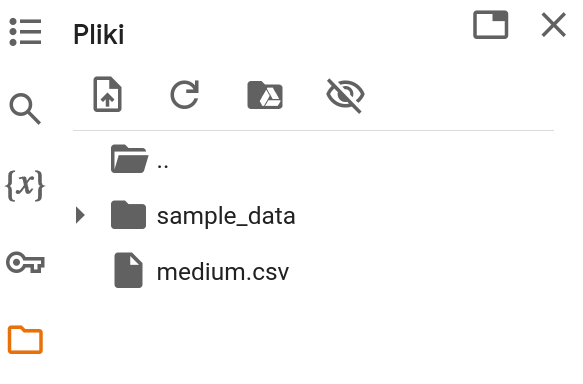

In [ ]:
df = pd.read_csv('medium.csv')
articles = DataFrameLoader(df, page_content_column = "Title")
document = articles.load()

print(document[0])

page_content='A Beginner’s Guide to Word Embedding with Gensim Word2Vec Model' metadata={'Text': '1. Introduction of Word2vec\n\nWord2vec is one of the most popular technique to learn word embeddings using a two-layer neural network. Its input is a text corpus and its output is a set of vectors. Word embedding via word2vec can make natural language computer-readable, then further implementation of mathematical operations on words can be used to detect their similarities. A well-trained set of word vectors will place similar words close to each other in that space. For instance, the words women, men, and human might cluster in one corner, while yellow, red and blue cluster together in another.\n\nThere are two main training algorithms for word2vec, one is the continuous bag of words(CBOW), another is called skip-gram. The major difference between these two methods is that CBOW is using context to predict a target word while skip-gram is using a word to predict a target context. Generall

# Loading LM model.
We will load our model from hugging face. To do it we use pipeline api, so we need to provide secret HF secret key. Instrution how to do it is below.


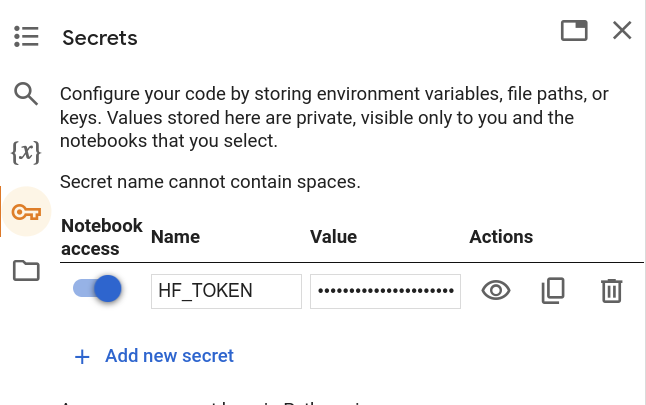

Click on Add new secret, select Notebook access, name the token HF_TOKEN, and paste the copied token in the Value field. This enables you to download pre-trained models from HuggingFace using the pipeline function.Note: if you run the following cell within Google colab, you will be asked to grant the notebook the access to the HF_TOKEN you have previously created.

# Grant access to model
**You have to grant access to gemma: https://huggingface.co/google/gemma-7b-it**. Loading it can take a while.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b-it")
model = AutoModelForCausalLM.from_pretrained("google/gemma-7b-it", device_map="auto", torch_dtype=torch.bfloat16)

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

# Example usage.
It can take while, if you have only one T4 GPU (around 1 minute).

In [ ]:
input_text = "What is Word2Vec?"
input_ids = tokenizer(input_text, return_tensors="pt").to("cuda")

outputs = model.generate(**input_ids, max_new_tokens=70)
print(tokenizer.decode(outputs[0]))

<bos>What is Word2Vec?

Word2Vec is a word embedding technique that learns meaningful word relationships from large text corpora. It is a popular technique for natural language processing (NLP) tasks such as word similarity, word analogy, and sentence completion.

**Key Concepts:**

* **Word Embeddings:** Represent words as dense vectors of numbers, where similar words have similar vectors


# Chunking
It's a process of extracting meaningful phrases, or "chunks," from a sentence based on its grammatical structure and parts of speech.

In this case chunking can help in text preprocessing, content selection or context segmentation.

In [ ]:
splitter = TokenTextSplitter(chunk_size=500, chunk_overlap=75)
splitted_texts = splitter.split_documents(document)

# Indexing
Now we need to put chunks into an index so that we are able to retrieve them easily when we want to find something in the document or answer questions. We use embedding model and vector Chroma database for this purpose.

In [ ]:
#initialize an embedding model
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

#create chroma database from provided documents
chroma_database = Chroma.from_documents(splitted_texts,
                                      embedding_model,
                                      persist_directory = 'chroma_db')

#convert chroma database into retriever
retriever = chroma_database.as_retriever()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Searching the articles
I'll execute a similarity search using a query against a Chroma database to retrieve the most similar documents. The 'k' parameter is responsible for how many articles we well retrieve, and 'max_chars' for how many characters from every document we will retrieve.

In [ ]:
def search_articles(query, k=1, max_chars=1000):
    articles_info = ""
    docs = chroma_database.similarity_search(query, k=k)

    for doc in docs:
        details = doc.to_json()['kwargs']
        article_title = details['page_content']
        article_text = details['metadata']['Text'][:max_chars] + ("..." if len(details['metadata']['Text']) > max_chars else "")
        articles_info += f"Article Title: {article_title}\nText: {article_text}\n\n"
    return articles_info



# Example usage.

In [ ]:
print(search_articles("What is Word2Vec?", k=2, max_chars=1000))

Article Title: A Beginner’s Guide to Word Embedding with Gensim Word2Vec Model
Text: 1. Introduction of Word2vec

Word2vec is one of the most popular technique to learn word embeddings using a two-layer neural network. Its input is a text corpus and its output is a set of vectors. Word embedding via word2vec can make natural language computer-readable, then further implementation of mathematical operations on words can be used to detect their similarities. A well-trained set of word vectors will place similar words close to each other in that space. For instance, the words women, men, and human might cluster in one corner, while yellow, red and blue cluster together in another.

There are two main training algorithms for word2vec, one is the continuous bag of words(CBOW), another is called skip-gram. The major difference between these two methods is that CBOW is using context to predict a target word while skip-gram is using a word to predict a target context. Generally, the skip-gram 

In [ ]:
print(search_articles("How to implement Gradient Descent?", k=1, max_chars=2000))

Article Title: Understanding the Mathematics behind Gradient Descent.
Text: “Premature optimization is the root of all evil.”

― Donald Ervin Knuth

Agile is a pretty well-known term in the software development process. The basic idea behind it is simple: build something quickly, ➡️ get it out there, ➡️ get some feedback ➡️ make changes depending upon the feedback ➡️ repeat the process. The goal is to get the product near the user and guide you with feedback to obtain the best possible product with the least error. Also, the steps taken for improvement need to be small and should constantly involve the user. In a way, an Agile software development process involves rapid iterations. The idea of — start with a solution as soon as possible, measure and iterate as frequently as possible, is Gradient descent under the hood.

Objective

Gradient descent algorithm is an iterative process that takes us to the minimum of a function(barring some caveats). The formula below sums up the entire Gra

In [ ]:
print(search_articles("What is Machine Learning?", k=3, max_chars=350))

Article Title: So what is Machine Learning?
Text: Photo by fabio on Unsplash

I am sure by now you must have heard about this term, and if surprisingly not, just have a look at the presentations by Apple or Google; even McDonald’s is doing something. In fact not only them, if you were to look at the Google Trends page for Machine Learning, you’ll notice the upward trend in popularity and interest ...

Article Title: Why Machine Learning?
Text: Image by the author

In my previous post I talked about the myriad terms used to describe various statistical/data science fields. I also mentioned that among those machine learning was one of the most powerful and popular subfields.

In the next series of posts I’m going to go deeper into machine learning. Rather than defining and explaining the v...

Article Title: Machine Learning Algorithms In Layman’s Terms, Part 2
Text: With that, onto the data science!

Now that we have covered gradient descent, linear regression, and logistic regression i

# Question answering system
I will first retrieve relevant articles to our query using 'search articles' function and then put them into the prompt, and instruct our model to answer on it's basis.

In [ ]:
def search_articles_and_answer(query, k=1, max_chars=1000):
    # Retrieve relevant articles
    articles_info = search_articles(query, k=k, max_chars=max_chars)

    # Prepare the prompt for question answering
    prompt = (
      f"Query: {query}\nContinue to answer the query by using the Search Results:\n{articles_info}."
    )
    # Answer the question based on the articles
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
    response = model.generate(**input_ids, max_new_tokens=80)
    print(tokenizer.decode(response[0]))



# Example usage.
It can take while, if you have only one T4 GPU (around 1 minute). This gemma model first displays it's prompt. After tirpe dot '...' there is its answer.

In [ ]:
query = "Describe Logistic Regression"
search_articles_and_answer(query)

<bos>Query: Describe Logistic Regression
Continue to answer the query by using the Search Results:
Article Title: Logistic Regression
Text: Logistic Regression

Contrary to its name logistic regression is a classification algorithm. Given an input example, a logistic regression model assigns the example to a relevant class.

A note on the notation. x_{i} means x subscript i and x_{^th} means x superscript th.

Quick Review of Linear Regression

Linear Regression is used to predict a real-valued output anywhere between +∞ and -∞.

Each example used to train a linear regression model is defined by its properties or features which are collectively called as the feature vector. Your name, age, contact number, gender, et-cetera correspond to a feature vector describing you.

A linear regression model f(x), is a linear combination of the features of the input examples x, and is represented by f(x) = wx+b.

Transforming the original features (consider a 1-dimensional feature vector x) by squa

In [ ]:
query = "Why should I use Cython?"
search_articles_and_answer(query)

<bos>Query: Why should I use Cython?
Continue to answer the query by using the Search Results:
Article Title: Use Cython to get more than 30X speedup on your Python code
Text: Cython will give your Python code super-car speed

Want to be inspired? Come join my Super Quotes newsletter. 😎

Python is a community favourite programming language! It’s by far one of the easiest to use as code is written in an intuitive, human-readable way.

Yet you’ll often hear the same complaint about Python over and over again, especially from the C code gurus out there: Python is slow.

And they’re not wrong.

Relative to many other programming languages, Python is slow. Benchmark game has some solid benchmarks for comparing the speed of various programming languages on different tasks.

There’s a couple of different ways to speed things up that I’ve written about before:

(1) Use multi-processing libraries to use all the CPU cores

(2) If you’re using Numpy, Pandas, or Scikit-Learn, use Rapids to acceler

In [ ]:
query = "What is Word2Vec?"
search_articles_and_answer(query)

<bos>Query: What is Word2Vec?
Continue to answer the query by using the Search Results:
Article Title: A Beginner’s Guide to Word Embedding with Gensim Word2Vec Model
Text: 1. Introduction of Word2vec

Word2vec is one of the most popular technique to learn word embeddings using a two-layer neural network. Its input is a text corpus and its output is a set of vectors. Word embedding via word2vec can make natural language computer-readable, then further implementation of mathematical operations on words can be used to detect their similarities. A well-trained set of word vectors will place similar words close to each other in that space. For instance, the words women, men, and human might cluster in one corner, while yellow, red and blue cluster together in another.

There are two main training algorithms for word2vec, one is the continuous bag of words(CBOW), another is called skip-gram. The major difference between these two methods is that CBOW is using context to predict a target wor

# Unrelated qustion to any article.

In [ ]:
query = "What is the name of main character of the series Peaky Blinders?"
search_articles_and_answer(query)

<bos>Query: What is the name of main character of the series peaky blinders?
Continue to answer the query by using the Search Results:
Article Title: APTOS 2019 Blindness Detection
Text: APTOS 2019 Blindness Detection

Image credits http://medi-whale.com

Diabetic retinopathy is a diabetes complication that affects eyes. Damage to the blood vessels of the light-sensitive tissue of the retina causes this complication. Diabetic retinopathy (DR) is a leading cause of vision-loss globally. Approximately one-third of 285 million people with diabetes mellitus worldwide have signs of DR.

Imagine being able to detect DR before it causes problems. Early detection of DR could save millions of diabetics from losing their vision, which is the goal of a problem featured in Kaggle by Asia Pacific Tele-Ophthalmology Society (APTOS).

Learn more about the competition here.

I was intrigued by the idea of detecting blindness in at-risk patients and that was my motivation for trying to use AI to solve 

# Try your own question

In [ ]:
query = ""
search_articles_and_answer(query)